## Cosmology - Problem Sheet 4

### Drishika Nadella

In [1]:
# Importing the relevant libraries

import numpy as np
import matplotlib.pyplot as plt
import h5py
import illustris_python as il
import matplotlib as mpl
from scipy.integrate import quad

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['legend.fontsize'] = 8

#### Loading the data

We load 4 different types of halo mass:

* ```GroupMass``` which is the mass of each halo.
* ```Group_M_Crit200``` which is the total mass of this halo enclosed in a sphere whose mean density is 200 times the critical density of the Universe at the given redshift.
* ```Group_M_Crit500``` which is the total mass of this halo enclosed in a sphere whose mean density is 500 times the critical density of the Universe at the given redshift.
* ```Group_M_Mean200``` which is the total mass of this halo enclosed in a sphere whose mean density is 200 times the mean density of the Universe at the given redshift.

In [2]:
# Define a base path
basePath = "/home/tnguser/sims.TNG/TNG50-4-Dark/output/"

In [3]:
nchunks = 4    # Number of chunks
snap = 99      # Snapshot corresponding to redshift z=0
z = 0          # Redshift

In [4]:
with h5py.File(basePath+'/groups_%03d/fof_subhalo_tab_%03d.%s.hdf5'%(snap,snap,0),'r') as f:
    
    header=(f['Header'])
    for key in header.attrs.keys():
        
        # Save the value of the Hubble parameter from the header
        if key=='HubbleParam':
            hub_tng50 = header.attrs[key]
            
        # Save the value of the Box size from the header
        if key=='BoxSize':
            bx_tng50 = header.attrs[key]

# Printing the Hubble Parameter
print("Hubble Parameter: ", hub_tng50)

Hubble Parameter:  0.6774


In [5]:
# Loading group mass, Mc200, Mc500 and Mm200
fields = ['GroupMass', 'Group_M_Crit200','Group_M_Crit500', 'Group_M_Mean200']
data = {field: [] for field in fields}

for num in range(0, nchunks):           
    with h5py.File(basePath+'/groups_%03d/fof_subhalo_tab_%03d.%s.hdf5'%(snap,snap,num),'r') as f:
                       
        for field in fields:           
            data[field].extend(np.array(f['Group'][field][:]))

Mc200 = np.asarray(data['Group_M_Crit200'])
Mc500 = np.asarray(data['Group_M_Crit500'])
Mm200 = np.asarray(data['Group_M_Mean200'])
Mfof = np.asarray(data['GroupMass'])

Mdict_tng50 = {'Mc200': Mc200, 'Mc500': Mc500, 'Mm200': Mm200, 'Mfof': Mfof}

The halo mass is given in terms of $10^{10} M_\odot / h$. To convert this into mass in units of $M_\odot$, we do the following:

$$ m_{phys} = \frac{m \times 10^{10} M_\odot}{h} $$

The simulation box size is given in terms of $\textrm{ckpc/h}$ where $\textrm{ckpc}$ is comoving kiloparsec and $\textrm{h}$ is the reduced Hubble parameter. To convert this into physical box size in units of $\textrm{Mpc}$, we multiply the comoving box size with the scale factor and divide by the reduced Hubble parameter as below:

$$ r_{phys} \textrm{ [Mpc] } = \frac{1}{1+z} \frac{r_{comov} \textrm{ [Mpc] }}{10^3 h}$$

In [6]:
def convert_mphys(m, h):
    phys_mass = m * 1e10 / h                        # Msun
    return phys_mass

for x, y in Mdict_tng50.items():
    Mdict_tng50[x] = convert_mphys(y, hub_tng50)

def convert_dphys(d, z, h):
    phys_d = 1. / (1. + z) * d / 1e3 / h            # Mpc
    return phys_d

L_tng50 = convert_dphys(bx_tng50, z, hub_tng50)
print(f"Physical simulation box length: {L_tng50:.2f} Mpc")
V_tng50 = L_tng50**3

Physical simulation box length: 51.67 Mpc


#### 1.1

Let us first convert the mass into log(mass). The reason I define a function for this is because simply doing ```np.log10(mass)``` leads to errors in the consequent steps where some log values are infinite since the some halo mass values are $0$.

In [7]:
def logmass(m):
    """
    Convert mass to log(mass) and discard undefined log values
    
    Inputs:
    ------
    m:       1D array of halo mass (Msun units)
    
    Outputs:
    -------
    logm:    1D array of log10(mass) with only defined values
    
    """
    logm = np.log10(m)
    logm = logm[np.isfinite(logm)]
    return logm

* Plotting the halo mass function as $\textrm{N}(>\textrm{MHalo})$ vs $\textrm{MHalo}$.

To plot $\textrm{N}(>\textrm{MHalo})$, I simply plot the cumulative histogram with ```cumulative=-1``` (to plot $\textrm{N}(>\textrm{MHalo})$ instead of the usual CDF $\textrm{N}(<\textrm{MHalo})$) and ```density=False```.

* Plotting the halo mass function as $\textrm{N/V}(>\textrm{MHalo})$ vs $\textrm{MHalo}$. 

To plot $\textrm{N/V}(>\textrm{MHalo})$, I plot the cumulative histogram with ```cumulative=-1``` and ```density=True```.

In [8]:
def plot_cumdist(M, ax, xlabel, ylabel, title, leglabel, density, yscale='log'):
    
    """
    Function to plot the differential halo mass functions for a given array of halo masses
    
    Inputs:
    ------
    M:        Array of halo masses (Msun)
    ax:       Plot axis 
    xlabel:   X-axis label
    ylabel:   Y-axis label
    title:    Plot title
    leglabel: Plot legend label
    density:  Histogram density (Boolean value)
    yscale:   Plotting scale for the Y-axis
    
    """
    
    for x, y in M.items():
        logm = logmass(M[x])
        ax.hist(logm, cumulative=-1, bins=30, density=density, linewidth=1.5, histtype='step', label = leglabel + f'{x}')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yscale(yscale)
    ax.legend()

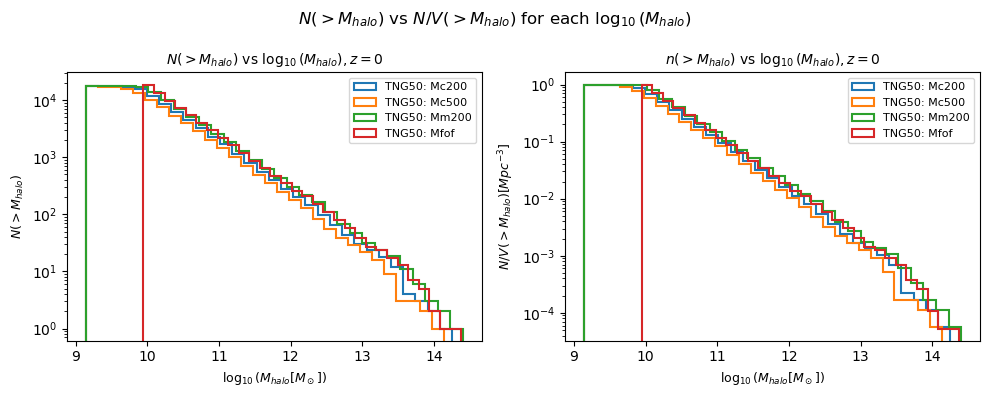

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plotting N(>Mhalo) vs log(Mhalo) (density=False in histogram)
plot_cumdist(Mdict_tng50, ax=ax1, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$N(>M_{halo})$', title=r'$N(>M_{halo})$ vs $\log_{10}(M_{halo}), z=0$', leglabel = 'TNG50: ', density=False)

# Plotting n(>Mhalo) vs log(Mhalo) (density=True in histogram)
plot_cumdist(Mdict_tng50, ax=ax2, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$N/V(>M_{halo}) [Mpc^{-3}]$', title=r'$n(>M_{halo})$ vs $\log_{10}(M_{halo}), z=0$', leglabel = 'TNG50: ', density=True)

plt.suptitle('$N(>M_{halo})$ vs $N/V(>M_{halo})$ for each $\log_{10}(M_{halo})$')
plt.tight_layout()
plt.show()

From the above plots, we can make a few observations:

* Most halos have low masses, with halo mass function steadily decreasing from $10^9 M_\odot$ to $10^{14} M_\odot$. This matches our expectation from theory, since low mass halos form earlier and are therefore more numerous.
* ```Mfof``` has the highest number of halos at every mass bin, whereas ```Mc500``` has the lowest number of halos at every mass bin. This is especially prominent in the high mass bin end. This makes sense because the criterion for ```Mc500``` is for the halo mass density to be 500 times the critical density, which is a stricter criterion than the other halo mass types, so you would expect to see lower number of ```Mc500``` halos.
* One important exception to the above statement is towards the lowest mass bin end, where the minimum halo mass for ```Mfof``` is higher than the minimum halo mass for the other mass types. Therefore, there are very few ```Mfof``` halos in the $10^9 M_\odot$ range. 

* How many haloes are more massive than $10^{12} M_\odot$ for the different types of masses?

In [10]:
for x, y in Mdict_tng50.items():
        logm = logmass(Mdict_tng50[x])
        print(f'{x}: {sum(logm > 12)} halos with greater mass than 10^12 Msun')

Mc200: 213 halos with greater mass than 10^12 Msun
Mc500: 167 halos with greater mass than 10^12 Msun
Mm200: 273 halos with greater mass than 10^12 Msun
Mfof: 273 halos with greater mass than 10^12 Msun


On average, there are about 200-250 halos with masses greater than a Milky Way like halo. Considering that in total, there are around 18,000 halos, we see that only around 1% of the halos are more massive than a Milky Way like halo.

* How more numerous are Milky Way like halos compared to halos of mass $10^{14} M_\odot$?

In [11]:
for x, y in Mdict_tng50.items():
        logm = logmass(Mdict_tng50[x])
        mint = logm.astype(int)
        m12 = sum(mint == 12)
        m14 = sum(mint == 14)
        print(f'{x}: {m12 - m14} more halos with mass 10^12 Msun compared to that of 10^14 Msun')

Mc200: 187 more halos with mass 10^12 Msun compared to that of 10^14 Msun
Mc500: 145 more halos with mass 10^12 Msun compared to that of 10^14 Msun
Mm200: 240 more halos with mass 10^12 Msun compared to that of 10^14 Msun
Mfof: 241 more halos with mass 10^12 Msun compared to that of 10^14 Msun


Since the halo mass function steadily declines with increasing halo mass, as expected, there are on average 200 halos more numerous in the $10^{12} M_\odot$ mass range as compared to that of $10^{14} M_\odot$.

* How rare are $10^{13} M_\odot$ mass halos compared to $10^{11} M_\odot$?

In [12]:
for x, y in Mdict_tng50.items():
        logm = logmass(Mdict_tng50[x])
        mint = logm.astype(int)
        m13 = sum(mint == 13)
        m11 = sum(mint == 11)
        print(f'{x}: {m13 / m11} times 10^13 Msun / 10^11 Msun halos')

Mc200: 0.015957446808510637 times 10^13 Msun / 10^11 Msun halos
Mc500: 0.016474464579901153 times 10^13 Msun / 10^11 Msun halos
Mm200: 0.01588170865279299 times 10^13 Msun / 10^11 Msun halos
Mfof: 0.014917421417155035 times 10^13 Msun / 10^11 Msun halos


Again, since the halo mass function steadily declines with increasing halo mass, there $10^{13} M_\odot$ mass halos are 100 times rarer compared to that of $10^{11} M_\odot$.

* What is the minimum halo mass you can plot?

In [13]:
for x, y in Mdict_tng50.items():
    logm = logmass(Mdict_tng50[x])
    print(f'{x}: Min. mass = {np.min(y):.2e} Msun, Min. mass plotted = 10^{np.min(logm):.2f} Msun')

Mc200: Min. mass = 0.00e+00 Msun, Min. mass plotted = 10^9.14 Msun
Mc500: Min. mass = 0.00e+00 Msun, Min. mass plotted = 10^9.14 Msun
Mm200: Min. mass = 0.00e+00 Msun, Min. mass plotted = 10^9.14 Msun
Mfof: Min. mass = 8.82e+09 Msun, Min. mass plotted = 10^9.95 Msun


The minimum halo mass for ```Mc200```, ```Mc500``` and ```Mm200``` is 0, but since I remove infinite log(mass) values, the minimum halo mass actually plotted for the aforementioned mass types is $10^{9.14} M_\odot$. For ```Mfof```, it is $10^{9.95} M_\odot$. While I am not sure why exactly these are the minimum values, we know that each DM particle is $1.9 \times 10^8 M_\odot /h$, and that each halo should have at least a few DM particles, it makes sense for the minimum halo mass to be around $10^9 M_\odot$. But why those specific values, and why ```Mfof``` has a higher minimum mass compared to the other 3 halo mass types, I am not sure.

#### 1.2

Let us compare the density distribution functions for ```TNG50-4-Dark``` and ```TNG100-3-Dark```. We have already loaded all of the required data for ```TNG50-4-Dark``` in the previous exercise. Now, loading the data for ```TNG100-3-Dark```.

In [14]:
# Define a base path
basePath2 = "/home/tnguser/sims.TNG/TNG100-3-Dark/output/"

nchunks_tng100 = 4    # Number of chunks
snap_tng100 = 99      # Snapshot corresponding to redshift z=0
z = 0                 # Redshift

In [15]:
with h5py.File(basePath2 + 'groups_%03d/fof_subhalo_tab_%03d.%s.hdf5'%(snap_tng100, snap_tng100, 0),'r') as f:

    header=(f['Header'])
    for key in header.attrs.keys():

        # Save the value of the Hubble parameter from the header
        if key=='HubbleParam':
            hub_tng100 = header.attrs[key]

        # Save the value of the Box size from the header
        if key=='BoxSize':
            bx_tng100 = header.attrs[key]

# Printing the Hubble Parameter
print("Hubble Parameter: ", hub_tng100)

Hubble Parameter:  0.6774


In [16]:
# Loading group mass, Mc200, Mc500 and Mm200
fields_tng100 = ['GroupMass', 'Group_M_Crit200','Group_M_Crit500', 'Group_M_Mean200']
data_tng100 = {field: [] for field in fields}

for num in range(0, nchunks_tng100):           
    with h5py.File(basePath2 + '/groups_%03d/fof_subhalo_tab_%03d.%s.hdf5'%(snap_tng100 ,snap_tng100, num),'r') as f:
                       
        for field in fields_tng100:           
            data_tng100[field].extend(np.array(f['Group'][field][:]))

Mc200_100 = np.asarray(data_tng100['Group_M_Crit200'])
Mc500_100 = np.asarray(data_tng100['Group_M_Crit500'])
Mm200_100 = np.asarray(data_tng100['Group_M_Mean200'])
Mfof_100 = np.asarray(data_tng100['GroupMass'])

Mdict_tng100 = {'Mc200': Mc200_100, 'Mc500': Mc500_100, 'Mm200': Mm200_100, 'Mfof': Mfof_100}
L_tng100 = convert_dphys(bx_tng100, z, hub_tng100)
print(f"Physical simulation box length for TNG100: {L_tng100:.2f} Mpc")
V_tng100 = L_tng100**3

Physical simulation box length for TNG100: 110.72 Mpc


We must also calculate the differential halo mass function for the 2 simulations, given by:

$$ f(M,z) = dN/\textrm{dlogM}/dV \textrm{  }[1/M_\odot/\textrm{Mpc}^3] $$

For this, I calculate $\log(M)$ from the given halo masses $M$, define some bins and calculate $N$ with ```np.hist```, calculate bin centers for $\log(M)$ for plotting and find $d\log(M)$ by $\log(M)[i+1] - \log(M)[i]$, then divide $N$ by $d\log(M) \times V$ (where $V$ is the simulation volume) to get $dN/\textrm{dlogM}/dV$.

In [17]:
def plot_diff_mf(M, V, ax, xlabel, ylabel, title, leglabel, density, yscale='log'):
    
    """
    Function to plot the differential halo mass functions for a given array of halo masses
    
    Inputs:
    ------
    M:        Array of halo masses (Msun)
    V:        Simulation volume (Mpc^3) (float for ex 1.2, 1.3 and dictionary with redshifts as keys for ex 1.4)
    ax:       Plot axis 
    xlabel:   X-axis label
    ylabel:   Y-axis label
    title:    Plot title
    leglabel: Plot legend label
    density:  Histogram density (Boolean value)
    yscale:   Plotting scale for the Y-axis
    
    """

    for x, y in M.items():
        
        logm = logmass(M[x])
        bins = np.linspace(logm.min(), logm.max(), 100)                      # Logarithmic bins
        counts, bin_edges = np.histogram(logm, bins=bins, density=density)   # Calculate the histogram
        
        # Calculate bin centers
        bin_centers = []
        for i in range(len(bin_edges)-1):
            binm = logm[(bin_edges[i] < logm) & (logm < bin_edges[i+1])]     # Find all halo masses within one bin
            bin_centers.append(np.median(binm))                              # Take bin center as median of these halo masses
        
        # Sim volume is a float for exercises 1.2 & 1.3, but a dictionary for ex 1.4 because of various redshifts
        if isinstance(V, float):
            dlogM = bin_edges[1:] - bin_edges[:-1]                   # Differential mass function (dn/dlogM)
            dn_dlogM = counts / (V * dlogM)                                 
        else:
            dlogM = bin_edges[1:] - bin_edges[:-1]                   # Differential mass function (dn/dlogM)
            # dn_dlogM = counts / (V[x] * dlogM)
            dn_dlogM = counts / dlogM
            
        ax.plot(bin_centers, dn_dlogM, label = leglabel + f'{x}')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yscale(yscale)
    # ax.set_ylim(1e-7, 50)
    # ax.set_xscale('log')
    ax.legend()

Now, we compare the cumulative and differential halo mass functions of ```TNG50-4-Dark``` and ```TNG100-3-Dark```.

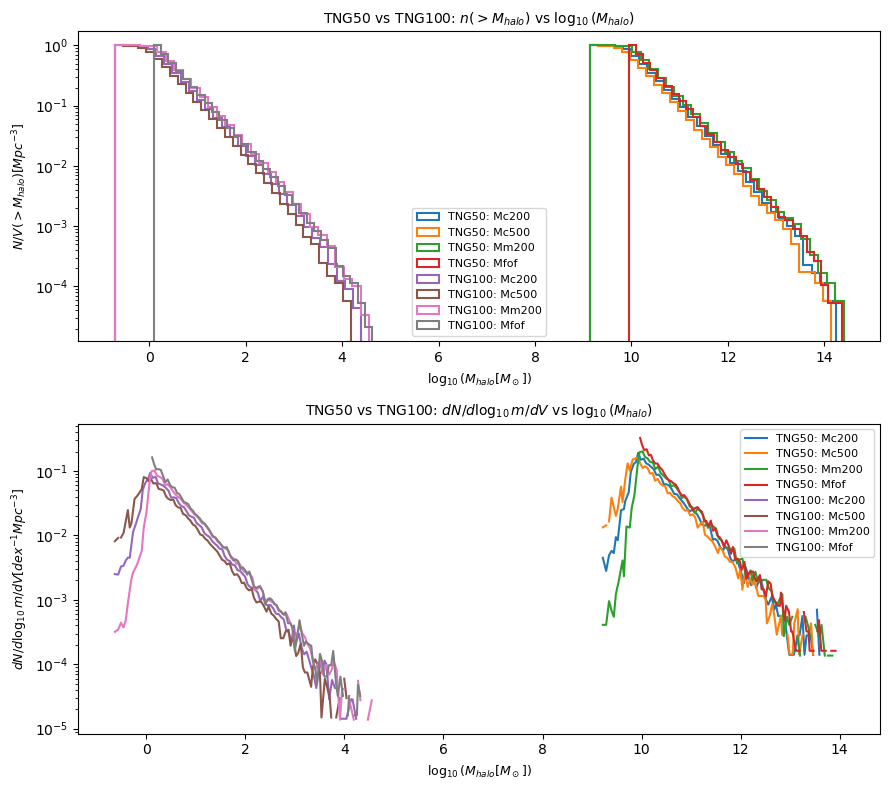

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))

# Plotting N/V(>Mhalo) vs log(Mhalo) for TNG50 vs TNG100
plot_cumdist(Mdict_tng50, ax=ax1, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$N/V(>M_{halo})$', title=r'TNG50 vs TNG100: $n(>M_{halo})$ vs $\log_{10}(M_{halo})$', leglabel = 'TNG50: ', density=True)
plot_cumdist(Mdict_tng100, ax=ax1, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$N/V(>M_{halo}) [Mpc^{-3}]$', title=r'TNG50 vs TNG100: $n(>M_{halo})$ vs $\log_{10}(M_{halo})$', leglabel = 'TNG100: ', density=True)

# Plotting dn/dlogM vs log(Mhalo) for TNG50 vs TNG100
plot_diff_mf(Mdict_tng50, V_tng50, ax=ax2, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$dN/d\log_{10}m/dV   [dex^{-1}Mpc^{-3}]$', title=r'TNG50 vs TNG100: $dN/d\log_{10}m/dV$ vs $\log_{10}(M_{halo})$', leglabel = 'TNG50: ', density=False)
plot_diff_mf(Mdict_tng100, V_tng100, ax=ax2, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$dN/d\log_{10}m/dV   [dex^{-1}Mpc^{-3}]$', title=r'TNG50 vs TNG100: $dN/d\log_{10}m/dV$ vs $\log_{10}(M_{halo})$', leglabel = 'TNG100: ', density=False)

plt.tight_layout()
plt.show()

Some observations on the cumulative HMF:

* We see that the ```TNG100``` simulation has significantly smaller halo masses compared to those of ```TNG50``` by $z=0$. The former has halo masses in the range of $10^0 - 10^4 M_\odot$, while the latter has halos in the range of $10^9 - 10^{14} M_\odot$. This is likely because ```TNG100``` has a box size of $110 \times 110 \times 110 \textrm{ Mpc}$ compared to a box size of $55 \times 55 \times 55 \textrm{ Mpc}$, which means that the former has a much larger simulation volume compared to the latter. So, it is harder for the DM particles to collapse into DM halos for ```TNG100``` and therefore requires a longer time to evolve into halos of bigger masses.
* Within the ```TNG100``` curves, we see that the curves of different mass types follow a similar pattern to that of ```TNG50```.

Some observations on the differential HMF:

* Again, we see that the ```TNG100``` simulation has significantly smaller halo masses compared to those of ```TNG50``` by $z=0$ likely due to the same reason as above.
* The different halo mass types lead to different HMF curves in the lower end of the halo masses, but at the higher end, all halo mass types have similar distributions.
* From the literature, I would expect that the differential HMF is relatively flat at the lower and middle halo mass ends and have a steep drop at the higher halo mass end, but we do not necessarily see that here. In these curves, the halo mass distribution increases to a maximum value and then steadily decreases to the higher mass end. I am not sure why the curves differ from the theoretical expectations or if I have made an error somewhere.

* How many objects above a mass of $10^{14} M_\odot$ in ```TNG50-4-Dark``` and ```TNG100-3-Dark```?

In [19]:
# Considering Mfof
lm50 = logmass(Mdict_tng50['Mfof'])
print(f'TNG50: {sum(lm50 > 14)} halos with greater mass than 10^14 Msun')

lm100 = logmass(Mdict_tng100['Mfof'])
print(f'TNG100: {sum(lm100 > 14)} halos with greater mass than 10^14 Msun')

TNG50: 2 halos with greater mass than 10^14 Msun
TNG100: 0 halos with greater mass than 10^14 Msun


There are 2 halos with a mass greater than $10^{14} M_\odot$ in the ```TNG50``` simulation, but none in ```TNG100``` since in the latter, because of the bigger simulation size in the latter which does not allow it to evolve into bigger mass halos in the same timeframe as the former.

* What are their typical number densities?

In [20]:
n14_50 = sum(lm50 > 14) / V_tng50
n14_100 = sum(lm100 > 14) / V_tng100
print(f'Number density of 10^14 Msun halos at z=0 for TNG50 is {n14_50:.3e} Msun / Mpc^3 and for TNG100 is {n14_100:.3e} Msun / Mpc^3')

Number density of 10^14 Msun halos at z=0 for TNG50 is 1.450e-05 Msun / Mpc^3 and for TNG100 is 0.000e+00 Msun / Mpc^3


#### 1.4 

Now loading data over several redshifts in ```TNG100-3-Dark``` to quantify the redshift evolution of the halo mass function:

In [21]:
snaps_tng100 = [99, 50, 33, 17, 4]      # Snapshot corresponding to redshifts 0,1,2,5,10 
zs = []                                 # Save redshifts from header to this list
Lz = []                                 # Save physical box size (Mpc) for each redshift to this list
Vz = {}                                 # Dictionary of sim. volumes for different redshifts

for snap in snaps_tng100:
    with h5py.File(basePath2 + 'groups_%03d/fof_subhalo_tab_%03d.%s.hdf5'%(snap, snap, 0),'r') as f:

        header=(f['Header'])
        for key in header.attrs.keys():

            # Save the value of the redshift from the header
            if key=='Redshift':
                z = header.attrs[key]
                zs.append(z)
                
            # Save the value of the Box size from the header
            if key=='BoxSize':
                bx = header.attrs[key]
                L = convert_dphys(bx, z, hub_tng100)
                Lz.append(L)
                
zs = np.round(np.asarray(zs), 2) 
Lz = np.round(np.asarray(Lz), 2)
print("Redshifts considered: ", zs)
print("Corresponding simulation box sizes in Mpc:", Lz)

# Find simulation volumes
for i in range(len(zs)):
    Vz[zs[i]] = Lz[i]**3.

Redshifts considered:  [ 0.  1.  2.  5. 10.]
Corresponding simulation box sizes in Mpc: [110.72 110.72  55.43  36.88  18.47]


In [22]:
# Loading group mass, Mc200, Mc500 and Mm200
fields_tng100 = ['GroupMass', 'Group_M_Crit200','Group_M_Crit500', 'Group_M_Mean200']
data_tng100 = {field: [] for field in fields}

def load_data(fields, df, snap, nchunks):
    
    for num in range(0, nchunks):           
        with h5py.File(basePath2 + '/groups_%03d/fof_subhalo_tab_%03d.%s.hdf5'%(snap, snap, num),'r') as f:
            for field in fields:           
                df[field].extend(np.array(f['Group'][field][:]))

    Mc200_100 = np.asarray(df['Group_M_Crit200'])
    Mc500_100 = np.asarray(df['Group_M_Crit500'])
    Mm200_100 = np.asarray(df['Group_M_Mean200'])
    Mfof_100 = np.asarray(df['GroupMass'])
    
    return Mc200_100, Mc500_100, Mm200_100, Mfof_100

Mc200_zs = {}
Mc500_zs = {}
Mm200_zs = {}
Mfof_zs = {}
for i in range(len(snaps_tng100)):
    a, b, c, d = load_data(fields_tng100, data_tng100, snaps_tng100[i], nchunks_tng100)
    Mc200_zs[zs[i]] = a
    Mc500_zs[zs[i]] = b
    Mm200_zs[zs[i]] = c
    Mfof_zs[zs[i]] = d

Plotting the cumulative halo mass function for each type of halo mass over several redshifts:

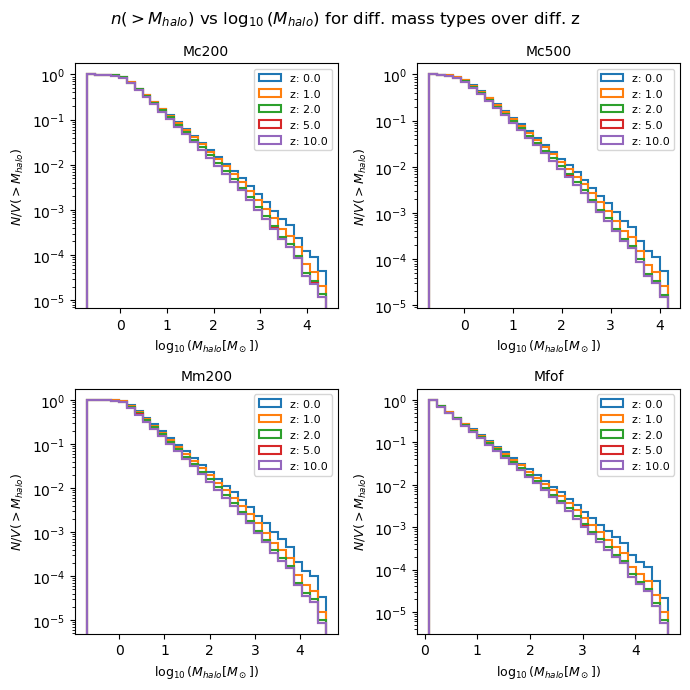

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))

# Plotting n(>Mhalo) vs log(Mhalo)
plot_cumdist(Mc200_zs, ax=ax1, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$N/V(>M_{halo})$', title=r'Mc200', leglabel='z: ', density=True)
plot_cumdist(Mc500_zs, ax=ax2, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$N/V(>M_{halo})$', title=r'Mc500', leglabel='z: ', density=True)
plot_cumdist(Mm200_zs, ax=ax3, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$N/V(>M_{halo})$', title=r'Mm200', leglabel='z: ', density=True)
plot_cumdist(Mfof_zs, ax=ax4, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$N/V(>M_{halo})$', title=r'Mfof', leglabel='z: ', density=True)

plt.suptitle(r"$n(>M_{halo})$ vs $\log_{10}(M_{halo})$ for diff. mass types over diff. z")
plt.tight_layout()
plt.show()

We see that, for increasing redshift, there is not much of a difference in the HMF at the low halo mass regime, but the number of halos with high mass decreases. This makes sense because we know from theory that low mass halos form early and high mass halos grow hierarchically later on. So, at increased redshifts i.e. at earlier times in the Universe's evolution, there was not enough time for structures to merge to form high mass halos, which is why they are lower in number at higher redshifts.

Now, plotting the differential halo mass function for each type of halo mass over several redshifts:

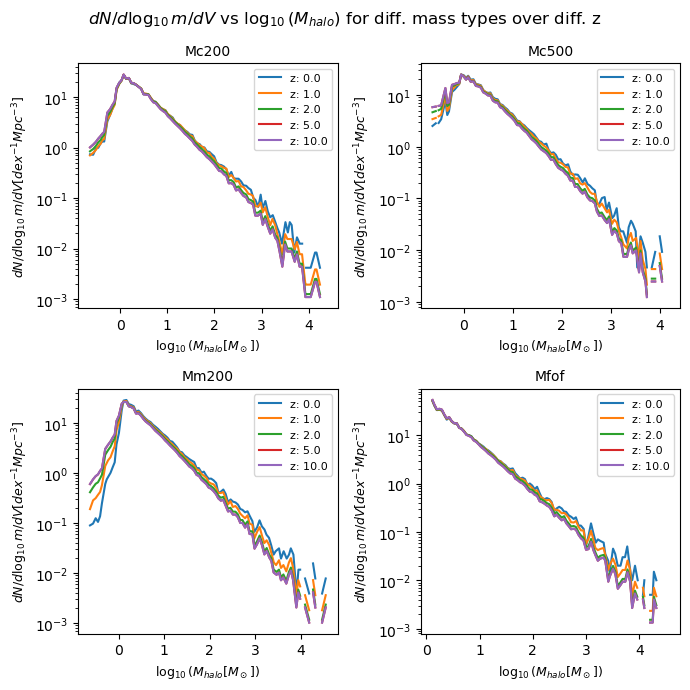

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))

# Plotting dn/dlogM vs log(Mhalo) for TNG50 vs TNG100
plot_diff_mf(Mc200_zs, Vz, ax=ax1, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$dN/d\log_{10}m/dV   [dex^{-1}Mpc^{-3}]$', title=r'Mc200', leglabel = 'z: ', density=True)
plot_diff_mf(Mc500_zs, Vz, ax=ax2, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$dN/d\log_{10}m/dV   [dex^{-1}Mpc^{-3}]$', title=r'Mc500', leglabel = 'z: ', density=True)
plot_diff_mf(Mm200_zs, Vz, ax=ax3, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$dN/d\log_{10}m/dV   [dex^{-1}Mpc^{-3}]$', title=r'Mm200', leglabel = 'z: ', density=True)
plot_diff_mf(Mfof_zs, Vz, ax=ax4, xlabel=r'$\log_{10}(M_{halo} [M_\odot])$', ylabel=r'$dN/d\log_{10}m/dV   [dex^{-1}Mpc^{-3}]$', title=r'Mfof', leglabel = 'z: ', density=True)

plt.suptitle(r"$dN/d\log_{10}m/dV$ vs $\log_{10}(M_{halo})$ for diff. mass types over diff. z")
plt.tight_layout()
plt.show()

Similar to the cumulative HMF, we see from the above differential HMF plots that, for increasing redshift, there is not much of a difference in the HMF at the low halo mass regime, but the number of halos with high mass decreases. This makes sense because we know from theory that low mass halos form early and high mass halos grow hierarchically later on. So, at increased redshifts i.e. at earlier times in the Universe's evolution, there was not enough time for structures to merge to form high mass halos, which is why they are lower in number at higher redshifts.

#### 2

The linear power spectrum is given by:

$$ P_{lin}(k, t) = D_+^2 (t) Ak^{n_s} T^2(k) $$

Let us consider each of the terms:

$D_+$ is the growth factor and can be calculated as follows:

$$ D_+(z) = \frac{1}{1+z} \frac{g(z)}{g(0)}$$ 

where $g(z)$ is given as:

$$ g(z) = \frac{5}{2} \frac{\Omega_m(z)}{\Omega^{4/7}_m(z) - \Omega_\Lambda(z) + \left(1 + \frac{\Omega_m(z)}{2}\right)\left(1 + \frac{\Omega_\Lambda(z)}{70}\right)}$$

This was already calculated in Sheet 3, so I borrow the same functions here:

In [25]:
def density_param(z, OM0, OR0, OL0):
    
    """
    Calculates the density parameter at a certain redshift for a given cosmological model
    
    Inputs:
    ------
    z:       Redshift
    OM0:     Present day matter density parameter
    OR0:     Present day radiation density parameter
    OL0:     Present day dark energy density parameter   
    
    Outputs:
    -------
    OMt, ORt, OLt:       Matter, radiation and dark energy density parameters at a given epoch
    """
    
    Ez2 = ((1. + z)**4. * OR0 + (1. + z)**3. * OM0 + (1 + z)**2. * (1. - OM0 - OR0 - OL0) + OL0)
    OMt = OM0 * (1. + z)**3. / Ez2
    ORt = OR0 * (1. + z)**4. / Ez2
    OLt = OL0 / Ez2
    
    return OMt, ORt, OLt

In [26]:
def g_z(z, Omz, Olz):
    
    """
    Calculates g(z) at a given redshift for a given cosmological model
    
    Inputs:
    ------
    z:        Redshift
    Omz:      Matter density parameter at given redshift z
    Olz:      Dark energy density parameter at given redshift z
    
    Outputs:
    -------
    gz:       g(z) at given redshift
    """
    
    gz = 2.5 * Omz / (Omz**(4./7.) - Olz + (1. + Omz / 2.) * (1. + Olz / 70.))
    return gz

In [27]:
def growth_factor(z, Om, Or, Ol):
    
    """
    Calculates the growth factor for a certain cosmological model and redshift
    
    Inputs:
    ------
    z:       Redshift
    Om:      Present day matter density parameter
    Or:      Present day radiation density parameter
    Ol:      Present day dark energy density parameter
    
    Outputs:
    -------
    dplus:   Growth factor for a given redshift and cosmological model using the Carroll1992 fitting formula
    """
    
    Omz, _, Olz = density_param(z, Om, Or, Ol)
    gz = g_z(z, Omz, Olz)            # Using parameter values at z=z for g(z)
    g0 = g_z(0, Om, Ol)              # Using parameter values at z=0 for g(0)
    dplus = 1. / (1. + z) * gz / g0
    return dplus

Now, the second term in $ P_{lin}(k, t) = D_+^2 (t) Ak^{n_s} T^2(k) $ where $k$ is the wavenumber, $n_s$ is the slope of the primordial power spectrum (given by the cosmological model) and $A$ is the amplitude, which can be calculated as:

$$ A = \frac{\sigma_8^2}{\frac{1}{2\pi^2} \int_0^\infty k^2 P_{lin}(k,z=0)W_{R8}(kR) dK}$$

where $P_{lin}(k,z=0) = k^{n_s}T^2(k)$ and $W_{R8}(kR)$ is given by:

$$ W_{R8}(kR) = \frac{3\left(\sin(kR) - kR \cos(kR)\right)}{(kR)^3} $$

where $R = 8\textrm{Mpc/h}$. Calculating these parameters:

In [28]:
def WR8(k, R):
    """
    Function to calculate the smoothing function
    
    Inputs:
    ------
    k:       Wavenumber array (1/Mpc)
    R:       Smoothing radius (Mpc/h)
    
    Outputs:
    -------
    Wr8:     Smoothing function 
    
    """
    Wr8 = 3 * (np.sin(k * R) - k * R * np.cos(k * R)) / (k * R)**3
    return Wr8

In [29]:
def integrand1(k, ns, h, Om, Ob, R):
    return k**2 * k**ns * BBKS_Tk(k, h, Om, Ob) * WR8(k, R)

def Amplitude(sigma8, k, ns, h, Om, Ob, R):
    """
    Calculates the amplitude of the linear power spectrum
    
    Inputs:
    ------
    sigma8:    Matter density fluctuation on a scale of 8 Mpc/h (defined by cosmological model) 
    k:         Wave number array (1/Mpc)
    ns:        Slope of primordial power spectrum (defined by cosmological model)
    h:         Reduced Hubble parameter
    Om:        Present-day matter density parameter (defined by cosmological model)
    Ob:        Present-day baryon matter density parameter (defined by cosmological model)
    R:         Smoothing radius (Mpc/h)
    
    Outputs:
    -------
    A:         Amplitude of primordial power spectrum
    
    """
    temp, _ = quad(integrand1, 0, np.inf, args=(ns, h, Om, Ob, R))
    temp = temp / (2. * np.pi**2)
    A = sigma8**2 / temp
    return A

Finally, the transfer function term $T(k)$ in $ P_{lin}(k, t) = D_+^2 (t) Ak^{n_s} T^2(k) $. Using the BBKS $T(k)$:

$$ T(q) = \frac{\ln(1 + 2.34q)}{2.34q} \frac{1}{\left(1 + 3.89q + (16.1q)^2 + (5.46q)^3 + (6.71q)^4 \right)^{1/4}} $$

where $q = k / \Gamma h$ and $\Gamma$ is the shape parameter given by:

$$ \Gamma = \Omega_m h \exp(-\Omega_b - \sqrt{2h} \frac{\Omega_b}{\Omega_m})$$

In [30]:
def BBKS_Tk(k, h, Om, Ob):
    """
    Calculates the Bardeen et al. (1986) transfer function
    
    Inputs:
    ------
    k:         Wave number array (1/Mpc)
    h:         Reduced Hubble parameter
    Om:        Present-day matter density parameter (defined by cosmological model)
    Ob:        Present-day baryon matter density parameter (defined by cosmological model)
    
    Outputs:
    -------
    Tk**2:     The SQUARE (!) of the transfer function
    
    """
    gamma = Om * h * np.exp(- Ob - np.sqrt(2 * h) * Ob / Om)
    q = k / (gamma * h)
    Tk = np.log(1. + 2.34 * q) / (2.34 * q) * 1. / (1 + 3.89 * q + (16.1 * q)**2. + (5.46 * q)**3. + (6.71 * q)**4.)**0.25
    return Tk**2

Combining all 3 terms to obtain the linear power spectrum:

In [31]:
def linear_Pspec(Dplus, A, ns, k, Tk2):
    """
    Calculates the linear power spectrum of the cosmological density fluctuations
    
    Inputs:
    ------
    Dplus:      Growth factor
    A:          Amplitude
    ns:         Primordial power spectrum (defined by cosmological model)
    k:          Wavenumber array (1/Mpc)
    Tk2:        Square of transfer function
    
    Outputs:
    -------
    Plin:       Linear power spectrum
    
    """
    Plin = Dplus**2 * A * k**ns * Tk2
    return Plin

In [32]:
# Define a plotting function

def plotting(x, y, ax, xlabel, ylabel, title, leglabel, xscale, yscale):
    """
    A general plotting function
    """
    ax.plot(x, y, label=leglabel)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.legend()

In [33]:
# Define cosmological parameters for the Einstein-de Sitter Universe
EdS = {'H0': 67.3, 'Om': 1., 'Ol': 0., 'Or': 0., 'k': 0., 'Ob': 0.049, 'sigma8': 0.829, 'ns': 0.96} 

# Define cosmological parameters the low matter density Universe
LowM = {'H0': 67.3, 'Om': 0.3, 'Ol': 0., 'Or': 0., 'k': 0., 'Ob': 0.049, 'sigma8': 0.829, 'ns': 0.96}

# Define cosmological parameters the LCDM Universe
LCDM = {'H0': 67.3, 'Om': 0.315, 'Ol': 0.685, 'Or': 2.47 * 1.e-5 / 0.67**2, 'Ob': 0.049, 'k': 0., 'sigma8': 0.829, 'ns': 0.96}

#### 2.1

We want to calculate and plot $P(k, z)$ vs $k$ in $\Lambda\textrm{CDM}$ for $z = [0, 1, 4]$. 

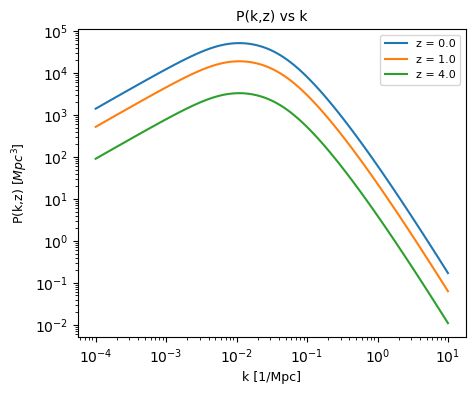

In [34]:
z_array = np.array([0., 1., 4.])           # Redshifts
k = np.logspace(-4, 1, 100)                # Wavenumbers [1/Mpc]
h = LCDM['H0'] / 100.                      # Reduced Hubble parameter [Mpc/km/s]
R = 8 / h                                  # [Mpc / h]

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))

for z in z_array:
    
    # Calculating D+ for the LCDM model
    dplus_LCDM = growth_factor(z, LCDM['Om'], LCDM['Or'], LCDM['Ol'])

    # Calculating amplitude
    A1 = Amplitude(LCDM['sigma8'], k, LCDM['ns'], h, LCDM['Om'], LCDM['Ob'], R)

    # Calculating transfer function
    Tk2_LCDM = BBKS_Tk(k, h, LCDM['Om'], LCDM['Ob'])

    # Linear power spectrum
    Plin = linear_Pspec(dplus_LCDM, A1, LCDM['ns'], k, Tk2_LCDM)
    
    # Plot
    plotting(k, Plin, ax=ax1, xlabel='k [1/Mpc]', ylabel=r'P(k,z) [$Mpc^3$]', title='P(k,z) vs k', leglabel=f'z = {z}', xscale='log', yscale='log')

Because of the transfer function, the power spectrum which increases at larger scales, then decreases at smaller scales to match observations and to accoutn for post-inflation. Increasing redshift leads to decreasing power spectrum at all scales as the density fluctuations have not had time to grow at higher redshifts i.e. at earlier times in the Universe.

#### 2.2

We want to plot $P(k, z=0)$ vs $k$ for the Einstein-de Sitter, low matter density and the $\Lambda\textrm{CDM}$ models. $k, R$ and $h$ remain the same across models, so we can continue to use those values from 2.1.

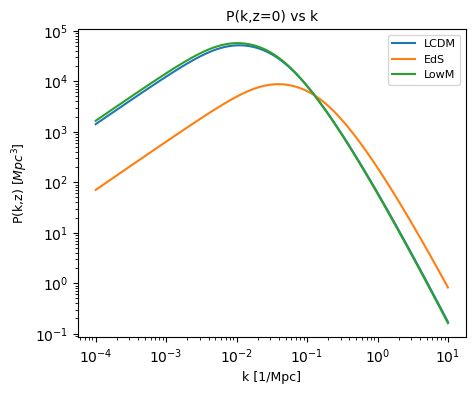

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))

################################################# LCDM Calculation ########################################################
    
# Calculating D+ for the LCDM model
dplus_LCDM = growth_factor(0, LCDM['Om'], LCDM['Or'], LCDM['Ol'])

# Calculating amplitude
A_LCDM = Amplitude(LCDM['sigma8'], k, LCDM['ns'], h, LCDM['Om'], LCDM['Ob'], R)

# Calculating transfer function
Tk2_LCDM = BBKS_Tk(k, h, LCDM['Om'], LCDM['Ob'])

# Linear power spectrum
Plin_LCDM = linear_Pspec(dplus_LCDM, A_LCDM, LCDM['ns'], k, Tk2_LCDM)

# Plot
plotting(k, Plin_LCDM, ax=ax1, xlabel='k [1/Mpc]', ylabel=r'P(k,z) [$Mpc^3$]', title='P(k,z=0) vs k', leglabel=f'LCDM', xscale='log', yscale='log')

################################################# EdS Calculation ########################################################
    
# Calculating D+ for the EdS model
dplus_EdS = growth_factor(0, EdS['Om'], EdS['Or'], EdS['Ol'])

# Calculating amplitude
A_EdS = Amplitude(EdS['sigma8'], k, EdS['ns'], h, EdS['Om'], EdS['Ob'], R)

# Calculating transfer function
Tk2_EdS = BBKS_Tk(k, h, EdS['Om'], EdS['Ob'])

# Linear power spectrum
Plin_EdS = linear_Pspec(dplus_EdS, A_EdS, EdS['ns'], k, Tk2_EdS)

# Plot
plotting(k, Plin_EdS, ax=ax1, xlabel='k [1/Mpc]', ylabel=r'P(k,z) [$Mpc^3$]', title='P(k,z=0) vs k', leglabel=f'EdS', xscale='log', yscale='log')

################################################# LowM Calculation ########################################################
    
# Calculating D+ for the lowM model
dplus_LowM = growth_factor(0, LowM['Om'], LowM['Or'], LowM['Ol'])

# Calculating amplitude
A_LowM = Amplitude(LowM['sigma8'], k, LowM['ns'], h, LowM['Om'], LowM['Ob'], R)

# Calculating transfer function
Tk2_LowM = BBKS_Tk(k, h, LowM['Om'], LowM['Ob'])

# Linear power spectrum
Plin_LowM = linear_Pspec(dplus_LowM, A_LowM, LowM['ns'], k, Tk2_LowM)

# Plot
plotting(k, Plin_LowM, ax=ax1, xlabel='k [1/Mpc]', ylabel=r'P(k,z) [$Mpc^3$]', title='P(k,z=0) vs k', leglabel=f'LowM', xscale='log', yscale='log')

plt.show()

Some observations on the above plot:

* We see that at larger scales (i.e. smaller wavenumbers $k$), structure formation is suppressed for the Einstein-de Sitter model, but not for LCDM or the low matter density models.
* At smaller scales (i.e. larger wavenumbers $k$), structure formation is higher for the EdS model compared to the LCDM and low matter density models.

#### 2.3

Finally, we want to plot $P(k, z)$ vs $k$ in $\Lambda\textrm{CDM}$ for $\sigma_8 = [0.7, 0.8, 0.9]$ (assuming $z=0$). $\sigma_8$ is the variance in the matter density field when it is smoothed over a scale of $8h^{-1}$ Mpc. Another way to think about $\sigma_8$ is that it measures the amplitude of the linear power spectrum on the scale of $8h^{-1}$ Mpc. 

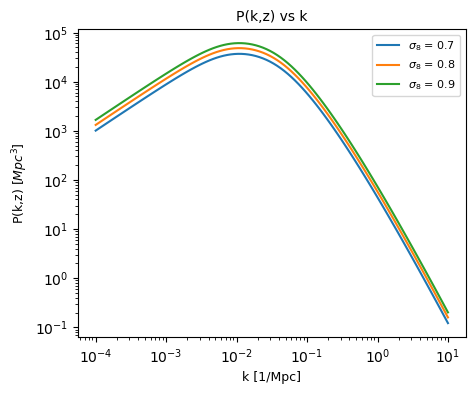

In [36]:
s8_array = np.array([0.7, 0.8, 0.9])           # sigma8
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))

for s8 in s8_array:
    
    # Calculating D+ for the LCDM model
    dplus_LCDM = growth_factor(0, LCDM['Om'], LCDM['Or'], LCDM['Ol'])

    # Calculating amplitude
    A1 = Amplitude(s8, k, LCDM['ns'], h, LCDM['Om'], LCDM['Ob'], R)

    # Calculating transfer function
    Tk2_LCDM = BBKS_Tk(k, h, LCDM['Om'], LCDM['Ob'])

    # Linear power spectrum
    Plin = linear_Pspec(dplus_LCDM, A1, LCDM['ns'], k, Tk2_LCDM)
    
    # Plot
    plotting(k, Plin, ax=ax1, xlabel='k [1/Mpc]', ylabel=r'P(k,z) [$Mpc^3$]', title='P(k,z) vs k', leglabel=r'$\sigma_8$ = {}'.format(s8), xscale='log', yscale='log')

We see that the density fluctuations are greater for $\sigma_8 = 0.9$ compared to those of $\sigma_8 = 0.8$ and $\sigma_8 = 0.7$. Since $\sigma_8$ is the measure of the variance of the matter density field, a higher $\sigma_8$ means a higher variance, and therefore higher matter density fluctuations, which is why $\sigma_8 = 0.9$ has the biggest power spectrum on all length scales (although not by much). Another interpretation is that since $\sigma_8$ is a measure of the amplitude of the linear power spectrum, $\sigma_8 = 0.9$ has the highest amplitude as seen in the plot.

Now, we want to calculate the mass variance of the linear density field $\sigma^2 (M, z)$. It is given by:

$$ \sigma^2 (M, z) = \frac{1}{2\pi^2} \int_0^\infty k^2 P_{lin}(k,z)W^2(k, M) dM $$

where $P_{lin}(k,z)$ is the linear power spectrum that we have just calculated in the function ```linear_Pspec```. To calculate the smoothing function $W^2(k, M)$, let us recall that:

$$ M = \frac{4}{3}\pi\rho_M R^3 $$

where $\rho_M$ is the matter density of the Universe. Therefore, 

$$ R = \left(\frac{3M}{4\pi\rho_M}\right)^{1/3} $$

We substitute this value of $R$ in the $W_{R8}(kR)$ formula:

$$ W_{R8}(kR) = \frac{3\left(\sin(kR) - kR \cos(kR)\right)}{(kR)^3} $$

to give $W(k, M)$. For the purpose of this exercise, I assume a value of $\rho_M = 0.315 \rho_{crit}$ where $\rho_{crit} = 8.43 \times 10^{-27} \textrm{kg/m}^3$ or $1.36 \times 10^{11} \textrm{M}_\odot/\textrm{Mpc}^3$.

In [37]:
def MtoR(m, rho):
    r = (3. * m / (4. * np.pi * rho))**(1. / 3.)
    # m = 4. / 3. * np.pi * rho * r**3
    return r

def Wmk(k, M, rho):
    R = MtoR(M, rho)
    Wkm = 3 * (np.sin(k * R) - k * R * np.cos(k * R)) / (k * R)**3
    return Wkm

In [38]:
def integrand2(k, s8, ns, h, Om, Ob, M, R, rho):
    return k**2 * Amplitude(s8, k, ns, h, Om, Ob, R) * k**ns * BBKS_Tk(k, h, Om, Ob) * Wmk(k, M, rho)**2

def sigma2M(k, Dplus, s8, ns, h, Om, Ob, M, R, rho):
    temp, _ = quad(integrand2, 0, np.inf, args=(s8, ns, h, Om, Ob, M, R, rho))
    sigma2 = temp / (2. * np.pi**2) * Dplus**2
    return sigma2

#### 2.4

We want to calculate and plot $\sigma^2(M, z)$ vs $M$ in $\Lambda\textrm{CDM}$ for $z = [0, 1, 4]$.

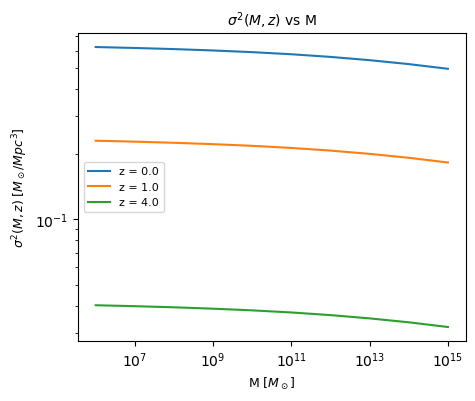

In [39]:
z_array = np.array([0., 1., 4.])           # Redshifts
k = np.logspace(-4, 1, 100)                # Wavenumbers [1/Mpc]
h = LCDM['H0'] / 100.                      # Reduced Hubble parameter 
rhom = LCDM['Om'] * 1.36e11                # Mean matter density [Msun / Mpc^3]
M = np.logspace(6, 15, 10)                 # Array of masses [Msun]
R = MtoR(M, rhom)                          # Radii [Mpc]

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))

for z in z_array:
    
    sigma2_LCDM = []
    for i in range(len(M)):
    
        # Calculating D+ for the LCDM model
        dplus_LCDM = growth_factor(z, LCDM['Om'], LCDM['Or'], LCDM['Ol'])

        # Calculating variance in matter density
        sigma2_LCDM.append(sigma2M(k, dplus_LCDM, LCDM['sigma8'], LCDM['ns'], h, LCDM['Om'], LCDM['Ob'], M[i], R[i], rhom))
    
    # Plot
    plotting(M, sigma2_LCDM, ax=ax1, xlabel=r'M [$M_\odot$]', ylabel=r'$\sigma^2(M,z)$ [$M_\odot / Mpc^3$]', title='$\sigma^2(M,z)$ vs M', leglabel=f'z = {z}', xscale='log', yscale='log')

While the shape of the plot may seem fine (i.e. $\sigma^2$ decreases with increasing mass), the magnitudes are clearly wrong. I am not sure where I am making a mistake. It is likely due to units, but I have verified my units so I am not sure. The correct plot should have $\sigma^2$ spanning several orders of magnitude over the different masses. However, we can still make some observations regarding the plot:

* $\sigma^2$ reduces with increasing mass or length scales. This makes sense because at very large scales, the Universe becomes homogeneous, therefore the mass density fluctuations decrease at large scales.
* $\sigma^2$ decreases with increasing redshift. Structure formation increases as Universe has had the time to evolve i.e. at smaller redshifts.

#### 2.5

Now, we calculate and plot $\sigma^2(M, z)$ vs $M$ in $\Lambda\textrm{CDM}$, but $\Omega_m = [0.2, 0.3, 0.4]$, thereby making $\Omega_\Lambda$ approximately $\Omega_\Lambda = [0.8, 0.7, 0.6]$. Also, we make the assumption that $\Omega_b$, the baryon matter density parameter remains the same.

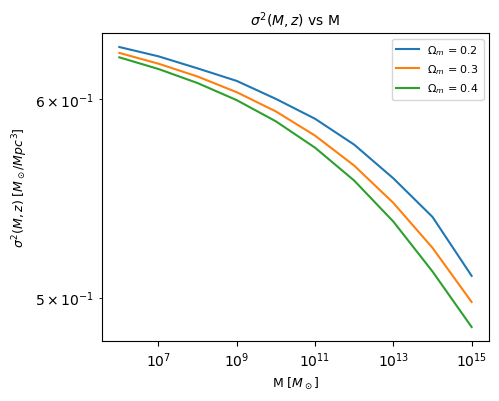

In [40]:
Om_array = np.array([0.2, 0.3, 0.4])           # Matter density parameter
Ol_array = 1 - Om_array

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))

for omind in range(len(Om_array)):
    
    sigma2_Om = []
    for i in range(len(M)):
    
        # Calculating D+ for the LCDM model
        dplus_Om = growth_factor(0, Om_array[omind], LCDM['Or'], Ol_array[omind])

        # Calculating ariance in matter density
        sigma2_Om.append(sigma2M(k, dplus_Om, LCDM['sigma8'], LCDM['ns'], h, Om_array[omind], LCDM['Ob'], M[i], R[i], rhom))
    
    # Plot
    plotting(M, sigma2_Om, ax=ax1, xlabel=r'M [$M_\odot$]', ylabel=r'$\sigma^2(M,z)$ [$M_\odot / Mpc^3$]', title='$\sigma^2(M,z)$ vs M', leglabel=r'$\Omega_m$ = {}'.format(Om_array[omind]), xscale='log', yscale='log')

$\sigma^2$ increases with decreasing $\Omega_m$. I am unsure as to why this is the case because I would have expected the opposite i.e. a smaller $\Omega_m$ leads to smaller $\sigma^2(M)$ because a higher matter density would cause more gravitational collapse into structures, and therefore, a higher structure formation and higher variance in the matter density field.

#### 3.1

Now, we compare several analytical halo mass functions (HMF). The analytical halo mass function is given by:

$$ \frac{dn}{dM}(z) = f(\sigma) \frac{\bar{\rho}_m}{M} \frac{d\ln[\sigma^{-1}(M,z)]}{dM} $$

where $\bar{\rho}_m$ is the mean background density which we will again assume as $0.315 \rho_{crit}$. $\sigma$ is given by:

$$ \sigma^2 (M, z) = \frac{1}{2\pi^2} \int_0^\infty k^2 P_{lin}(k,z)W^2(k, M) dM $$

Different prescriptions of the HMF vary in their definition of $f(\sigma)$. 

* Press & Schechter HMF (1974):

$$ f_{PS}(\sigma) = \sqrt{\frac{2}{\pi}} \frac{\delta_c}{\sigma} \exp\left( \frac{-\delta_c^2}{2\sigma^2} \right)$$

where $\delta_c = 1.686$.

* Sheth & Tormen (1999):

$$ f_{ST}(\sigma) = A \sqrt{\frac{2a}{\pi}} \frac{\delta_c}{\sigma} \exp\left( \frac{-a \delta_c^2}{2\sigma^2} \right) \left(1 + \left(\frac{\sigma^2}{a \delta_c^2}\right)^p \right) $$

parameterized by $A = 0.322$, $p = 0.3$ and $a = 0.707$.

* Tinker et. al. (2008):

$$ f(\sigma) = A \left[ \left( \frac{\sigma}{b} \right)^{-a} + 1 \right] \exp \left( - \frac{c}{\sigma^2}\right)$$

where there are several ways to define $A, a, b, c$. 

Defining the $f(\sigma)$ functions for each HMF:

In [41]:
def Press_Schechter(sigma, delc=1.686):
    """
    Calculate f(sigma) in the Press-Schechter formalism
    
    Inputs:
    ------
    sigma:   Variance of matter density field for array of masses
    delc:    Parameter defined for PS HMF (default: 1.686)
    
    Outputs:
    -------
    fPS:     f(sigma) for Press-Schechter function
    """
    
    fPS = np.sqrt(2. / np.pi) * (delc / sigma) * np.exp(-delc**2 / (2 * sigma**2))
    return fPS

In [42]:
def Sheth_Tormen(sigma, delc=1.686, A=0.322, a=0.707, p=0.3):
    """
    Calculate f(sigma) in the Sheth-Tormen formalism
    
    Inputs:
    ------
    sigma:   Variance of matter density field for array of masses
    delc:    Parameter defined for ST HMF (default: 1.686)
    A, a, p: Also parameters defined for ST HMF (default A=0.322, a=0.707, p=0.3)
    
    Outputs:
    -------
    fST:     f(sigma) for Sheth-Tormen function
    """
    
    temp = 1 + (sigma**2 / (a * delc**2))**p
    fST = A * np.sqrt(2. * a / np.pi) * (delc / sigma) * np.exp(- a * delc**2 / (2 * sigma**2)) * temp
    return fST

In [43]:
def Tinker(sigma, A, a, b, c):
    """
    Calculate f(sigma) in the Tinker formalism
    
    Inputs:
    ------
    sigma:        Variance of matter density field for array of masses
    A, a, b, c:   Parameters defined for Tinker HMF (values depend on type of Tinker function)
    
    Outputs:
    -------
    fT:     f(sigma) for Tinker function
    """
    
    fT = A * ((sigma / b)**(-a) + 1) * np.exp(-c / sigma**2)
    return fT

Now, defining the halo mass function:

In [44]:
def HMF_anl(sigma, rhom, M, model, tparam=0):
    """
    Calculates analytical HMF for different formalisms of HMF
    
    Inputs:
    ------
    sigma:   Variance of matter density field for array of masses
    rhom:    Mean matter density (Msun / Mpc^3)
    M:       Array of halo masses (Msun)
    model:   Analytical HMF formalism to use (PS = Press-Schechter, ST = Sheth-Tormen, T = Tinker)
    tparam:  Dictionary of Tinker parameters A, a, b, c (default = 0 if PS or ST used)
    
    Outputs:
    -------
    dndM:    Analytical halo mass function 
    """
    
    # Choose the right model for f(sigma)
    if model == 'PS':
        f = Press_Schechter(sigma)
    elif model == 'ST':
        f = Sheth_Tormen(sigma)
    elif model == 'T':
        f = Tinker(sigma, tparam['A'], tparam['a'], tparam['b'], tparam['c'])
    
    # Calculate dn/dM
    x = np.log(1. / sigma)
    dx = np.gradient(x)
    dM = np.gradient(M)
    dndM = f * rhom / M * dx / dM
    return dndM

Let us define a dictionary for different types of Tinker parameters. We consider the ```Tinker200```, ```Tinker400``` and the ```Tinker800``` parameters.

In [45]:
T200 = {'A': 0.186, 'a': 1.47, 'b': 2.57, 'c': 1.19}
T400 = {'A': 0.212, 'a': 1.56, 'b': 2.05, 'c': 1.34}
T800 = {'A': 0.248, 'a': 1.87, 'b': 1.59, 'c': 1.58}

Now, we can calculate and plot the HMF for each analytical prescription:

In [46]:
# Calculating sigma

rhom = LCDM['Om'] * 1.36e11                # Mean matter density [Msun / Mpc^3]
M = np.logspace(10, 15, 30)                # Array of masses [Msun]
R = MtoR(M, rhom)                          # Radii [Mpc]
sigma2 = []

for i in range(len(M)):
    
    # Calculating D+ for the LCDM model
    dplus_LCDM = growth_factor(0, LCDM['Om'], LCDM['Or'], LCDM['Ol'])

    # Calculating variance in matter density
    sigma2.append(sigma2M(k, dplus_LCDM, LCDM['sigma8'], LCDM['ns'], h, LCDM['Om'], LCDM['Ob'], M[i], R[i], rhom))
    
sigma = np.sqrt(np.asarray(sigma2))

In [47]:
# Calculating HMF for Press-Schechter, Sheth-Tormen, Tinker200, Tinker400, Tinker800 respectively

HMF_PS = HMF_anl(sigma, rhom, M, 'PS')
HMF_ST = HMF_anl(sigma, rhom, M, 'ST')
HMF_T200 = HMF_anl(sigma, rhom, M, 'T', tparam = T200)
HMF_T400 = HMF_anl(sigma, rhom, M, 'T', tparam = T400)
HMF_T800 = HMF_anl(sigma, rhom, M, 'T', tparam = T800)

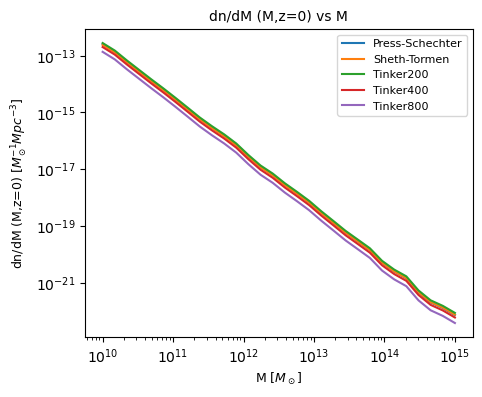

In [48]:
# Plotting the HMF

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(M, HMF_PS, label='Press-Schechter')
ax.plot(M, HMF_ST, label='Sheth-Tormen')
ax.plot(M, HMF_T200, label='Tinker200')
ax.plot(M, HMF_T400, label='Tinker400')
ax.plot(M, HMF_T800, label='Tinker800')
ax.set_xlabel(r'M [$M_\odot$]')
ax.set_ylabel(r'dn/dM (M,z=0) [$M_\odot^{-1} Mpc^{-3}$]')
ax.set_title(r'dn/dM (M,z=0) vs M')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.show()

While the numerical differential HMF derived in the previous questions had a peak before decreasing, the analytical HMFs decrease monotonically with increasing halo mass. This is in line with our expectation since we know that smaller mass halos are more abundant than massive halos. The different analytical halo mass functions look similar here. Let us try to better understand the differences between them by comparing all of them to the ```Tinker400``` HMF.

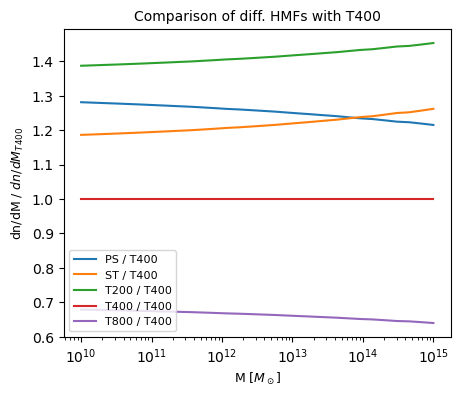

In [49]:
# Plotting the comparisons of various HMFs with Tinker400

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(M, HMF_PS / HMF_T400, label='PS / T400')
ax.plot(M, HMF_ST / HMF_T400, label='ST / T400')
ax.plot(M, HMF_T200 / HMF_T400, label='T200 / T400')
ax.plot(M, HMF_T400 / HMF_T400, label='T400 / T400')
ax.plot(M, HMF_T800 / HMF_T400, label='T800 / T400')
ax.set_xlabel(r'M [$M_\odot$]')
ax.set_ylabel(r'dn/dM / $dn/dM_{T400}$')
ax.set_title(r'Comparison of diff. HMFs with T400')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()

plt.show()

We see from above that the Press-Schechter, Sheth-Tormen and the Tinker200 prescriptions predict about 20-40% more halos compared to Tinker400, whereas Tinker800 predicts about 30% less halos compared to Tinker400 at all halo mass ranges.

#### 3.2

Let us now check if the mass function is independent of the redshift. Let us plot $f(\sigma)$ vs $1/\sigma$ for $z = [0., 1., 4.]$. For this, we will choose the Press-Schechter formalism.

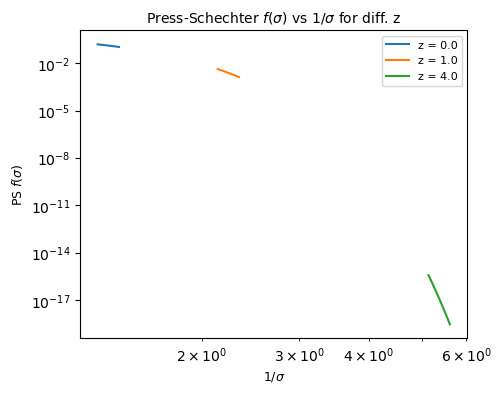

In [50]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))

for z in z_array:

    sigma2_z = []
    for i in range(len(M)):
    
        # Calculating D+ for the LCDM model
        dplus_LCDM = growth_factor(z, LCDM['Om'], LCDM['Or'], LCDM['Ol'])

        # Calculating ariance in matter density
        sigma2_z.append(sigma2M(k, dplus_LCDM, LCDM['sigma8'], LCDM['ns'], h, LCDM['Om'], LCDM['Ob'], M[i], R[i], rhom))
    
    sigma_z = np.sqrt(np.asarray(sigma2_z))
    fsigma_z = Press_Schechter(sigma_z)
    # Plot
    plotting(1. / sigma_z, fsigma_z, ax=ax1, xlabel=r'$1/\sigma$', ylabel=r'PS $f(\sigma)$', title='Press-Schechter $f(\sigma)$ vs $1/\sigma$ for diff. z', leglabel=f'z = {z}', xscale='log', yscale='log')

Again, the plot does not look right, likely because of the propagation of error from $\sigma^2(M, z)$ calculation in the previous questions. But what is expected is that curves from all 3 redshifts look identical, proving that in terms of $\sigma$, the DM halo mass function is Universal.